### A few tests where we explore cross validation, LOSO and use of GridSearchCV to select parameters for the model

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [3]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    subject_index = int(fname.split('/')[-1].split('.')[0][-1])
    dp = DP.dataprocess(fname,T=512,stride=512)
    
    #For LOSO, we need subjectID in the final dataframe
    dp.df['subjectID'] = int(subject_index)*np.ones(len(dp.df))
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

In [4]:
feature_df.to_csv("Features_df_with_subject.dat",index=False)

### First, an example of classification with cross validation

In [6]:
Y = feature_df['activityID']
X = feature_df.drop(['activityID','subjectID'],axis=1)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [171]:
RF = RandomForestClassifier(n_estimators=50,min_samples_split=2,min_samples_leaf=1,max_depth=12,oob_score=True)

In [172]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [173]:
RF.oob_score_

0.9739754711337122

In [174]:
RF.score(X_test,y_test)

0.9832635983263598

Do 5 fold cross validation (split into 5, train on 4 and test one 1). We do this on the training dataset and choose hyperparmeters in order to maximize these scores. We then test on the hold out (testing) dataset

In [175]:
cv_results = cross_validate(RF,X_train,y_train,cv=5)

In [176]:
cv_results['test_score']

array([0.97633136, 0.98809524, 0.97005988, 0.96546547, 0.98184569])

#### Do LOSO

In this approach, we first split the data into training and hold-out sets, then we do LOSO on the training set. This involves removing each subject in turn, fitting the remainder and then testing on the subject that has been held out. Once the hyperparemeters are tuned, the we can test on the hold out set.

In [181]:
RF = RandomForestClassifier(n_estimators=100,min_samples_split=2,min_samples_leaf=10,max_depth=12,oob_score=True)

In [182]:
Y = feature_df['activityID']

In [183]:
def LOSO(full_df,Y,classifier):
    
    '''
    Do Leave-One-Subject-Out cross validation on the full dataset
    '''
    
    #Do a test-train split. This is just to get the dataframe X_train_full, which contains all the information
    #we need to do the cross validation
    
    #Once we've turned to hyperparameters, we can test the model on X_test_holdout and Y_test_holdout
    
    X_train_full, X_test_holdout, Y_train_full, Y_test_holdout = train_test_split(full_df,Y,test_size=0.3)
    
    ######
    #Do cross validation 
    ######
    
    subject_scores = {}
    
    for subjectID in X_train_full['subjectID'].unique():
        
        print("Holding out subject %i" %subjectID)
        
        #Build test dataset - select just that subject and their associated activities
        X_test = X_train_full[X_train_full['subjectID']==subjectID]
        Y_test = X_test['activityID'].copy()
        X_test.drop(['activityID','subjectID'],inplace=True,axis=1)
        
        #Build training dataset - select all but that subject and their associated activities
        X_train = X_train_full[X_train_full['subjectID']!=subjectID]
        Y_train = X_train['activityID'].copy()
        X_train.drop(['activityID','subjectID'],inplace=True,axis=1)
        
        RF.fit(X_train,Y_train)
        
        score = RF.score(X_test,Y_test)
        subject_scores[str(subjectID)] = score 
        
    return subject_scores
        
        

In [184]:
scores = LOSO(feature_df,Y,classifier=RF)

Holding out subject 6


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 7


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 4


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 5


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 9


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 8


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 1


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 2


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Holding out subject 3


/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [185]:
scores

{'1.0': 0.4365482233502538,
 '2.0': 0.9678456591639871,
 '3.0': 0.7652582159624414,
 '4.0': 0.9481481481481482,
 '5.0': 0.8732943469785575,
 '6.0': 0.7773019271948608,
 '7.0': 0.945054945054945,
 '8.0': 0.7088353413654619,
 '9.0': 0.5265700483091788}

#### Set up pipeline and do grid search CV for optimal parameters. We could then apply the LOSO to this parameter choice

In [192]:
#Scaler
Scaler = StandardScaler()

#Random forest classifier
RF = RandomForestClassifier()

#Feature selector
FS = SelectFromModel(RF, threshold='mean',prefit=False)

In [270]:
parameters = {
    'classify__n_estimators': (100, 150, 200, 250),
    'classify__min_samples_leaf': (1,4,8,16),
    'classify__max_depth': (10,20,30),
    'classify__class_weight':("balanced","balanced_subsample"),
    'classify__criterion':('gini','entropy')
}

In [271]:
RF_pipeline = Pipeline([('scale', Scaler), ('select', FS), ('classify', RF)])

In [272]:
grid_search = GridSearchCV(RF_pipeline, parameters, verbose=1)

In [273]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in RF_pipeline.steps])
print("parameters:")
print(parameters)
t0 = time.time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['scale', 'select', 'classify']
parameters:
{'classify__n_estimators': (100, 150, 200, 250), 'classify__min_samples_leaf': (1, 4, 8, 16), 'classify__max_depth': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample'), 'classify__criterion': ('gini', 'entropy')}
Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed: 30.7min finished


done in 1841.852s

Best score: 0.984
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__criterion: 'gini'
	classify__max_depth: 30
	classify__min_samples_leaf: 1
	classify__n_estimators: 100


In [237]:
 p = grid_search.best_estimator_

In [246]:
best_RF = p.named_steps['classify']

In [269]:
np.sort(best_RF.feature_importances_)[::-1]

array([0.03857762, 0.0319761 , 0.03150811, 0.02751249, 0.02662214,
       0.02391703, 0.02367589, 0.02365384, 0.02269895, 0.02229349,
       0.0218981 , 0.02144756, 0.01940932, 0.01871196, 0.0184965 ,
       0.01809593, 0.01704828, 0.0166539 , 0.0159152 , 0.0158756 ,
       0.01570837, 0.01547228, 0.01530927, 0.01490958, 0.01480182,
       0.01480124, 0.01448402, 0.01427629, 0.01341669, 0.01321305,
       0.01318054, 0.01283046, 0.01265329, 0.01261023, 0.01239089,
       0.01222664, 0.01219246, 0.01179101, 0.01164211, 0.01153085,
       0.0114392 , 0.01117445, 0.01109701, 0.0109553 , 0.01090447,
       0.01062186, 0.01054972, 0.01013581, 0.01008698, 0.01002389,
       0.00967712, 0.0096193 , 0.00955296, 0.00954148, 0.00946   ,
       0.00920573, 0.00919049, 0.00826629, 0.00803915, 0.00793801,
       0.00691249, 0.00661293, 0.00639699, 0.0062505 , 0.00624353,
       0.00620099, 0.0059855 , 0.00597978, 0.00595135, 0.00568049,
       0.00516129, 0.00504343, 0.0046724 ])

In [250]:
best_selector = p.named_steps['select']

In [256]:
X_new = best_selector.transform(X)

In [264]:
sum(best_selector.get_support()) #Note that best_selector.get_support is the list of used columns

73

### Testing functions in parameter_feature_search

In [4]:
from parameter_feature_search import *

In [5]:
feature_df = pd.read_csv("Features_df_with_subject.dat")

In [6]:
Y = feature_df['activityID']
X = feature_df.drop(['activityID','subjectID'],axis=1)

#### Set up inputs for initial hyperparameter search function

In [11]:
model = RandomForestClassifier()

parameters = {
    'classify__n_estimators': (1,1),
    'classify__min_samples_leaf': (1,4,10),
    'classify__max_depth': (10,20,None),
    'classify__class_weight':("balanced","balanced_subsample"),
    'classify__criterion':('gini','entropy')
}

#### Select optimal hyperparemeters and an estimate of the best feature columns

In [12]:
X_new, best_classifier = test_model_initial(model,X,Y,parameters)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (1, 1), 'classify__min_samples_leaf': (1, 4, 10), 'classify__max_depth': (10, 20, None), 'classify__class_weight': ('balanced', 'balanced_subsample'), 'classify__criterion': ('gini', 'entropy')}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   40.2s finished


done in 40.736s

Best score: 0.895
Best parameters set:
	classify__class_weight: 'balanced'
	classify__criterion: 'entropy'
	classify__max_depth: 20
	classify__min_samples_leaf: 1
	classify__n_estimators: 1
Hold out score: 0.881


In [18]:
len(X_new.columns)

65

#### Select optimal feature columns using genetic algorithm

In [13]:
GA = Run_GA(X,Y,best_classifier)
GA.fit()

GeneticAlgorithm: Testing generation 1
GeneticAlgorithm: Testing generation 2
GeneticAlgorithm: Testing generation 3
GeneticAlgorithm: Testing generation 4
GeneticAlgorithm: Testing generation 5
GeneticAlgorithm: Testing generation 6
GeneticAlgorithm: Testing generation 7
GeneticAlgorithm: Testing generation 8
GeneticAlgorithm: Testing generation 9


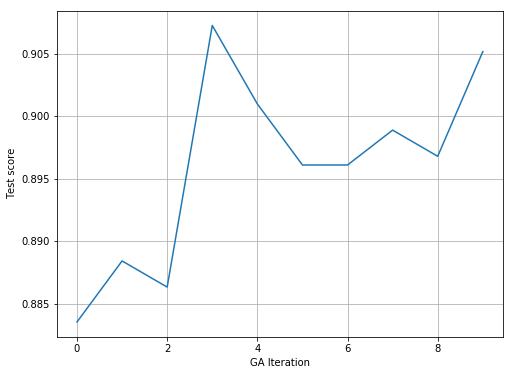

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(GA.fitness_evolution)
ax.set_xlabel('GA Iteration')
ax.set_ylabel('Test score')
plt.grid()

In [19]:
GA.best_fitness

0.905160390516039

In [17]:
len(GA.feature_selection.columns)

104

#### Do LOSO

In [20]:
new_features = GA.feature_columns + ['activ']
X_feature_select = 

In [ ]:
subject_scores = LOSO(feature_df,)